# **Socio-emotional Coping through *Music Making*: LGBM Regression**
Lindsay Warrenburg  
lindsay.a.warrenburg@gmail.com  
Final version: December 20, 2020

### This script describes a machine learning approach to investigate how people used *music making* to cope with the social and emotional stress of the coronavirus crisis. 

- It shows how the data do not meet linearity assumptions and therefore require a non-linear method
- The results of the LGBM regression model are presented, along with SHAP value plots assessing feature importance.

In [1]:
import numpy as np, pandas as pd, os, sys, itertools, seaborn as sns, re, warnings, math, scipy as sp, lightgbm as lgb, sklearn, shap, matplotlib.pyplot as plt, matplotlib.cm as cm, statsmodels.stats.api as sms, statsmodels.api as sm
from sklearn import preprocessing, metrics, manifold
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer, confusion_matrix, plot_confusion_matrix, classification_report 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.compat import lzip
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.regressionplots import plot_leverage_resid2
from IPython.display import Image, HTML
from matplotlib.ticker import NullFormatter

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
%matplotlib inline
plt.rcParams['figure.figsize'] = (14,4)
warnings.filterwarnings(action='ignore')
%run Coronavirus_Music_Functions.ipynb

### **Data Pre-Processing**

In [2]:
all_data = pd.read_csv("cleaned_data.csv")
all_data.drop(columns=['Demographics_General_Gender','date','ESM_ID','ID'], inplace=True)
original_n = len(all_data)
print(original_n, "total participants in the survey.")

5113 total participants in the survey.


In [3]:
# only keep people in performing and both groups
data = all_data[all_data['Survey Info_Group'].isin(['both','performing only'])].reset_index(drop=True)
new_n = len(data)
print(original_n-new_n, "people were removed because they didn't answer any of the performing questions.")
data['Survey Info_Group'].value_counts()

2083 people were removed because they didn't answer any of the performing questions.


both               3003
performing only      27
Name: Survey Info_Group, dtype: int64

In [4]:
# drop listening and formats and Survey Info_Group
col_list = [c for c in data.columns if not c.startswith('Music Listening_') and '_Formats_' not in c and c != 'Survey Info_Group']
data = data[col_list].reset_index(drop=True)

In [5]:
# rename columns
data.rename(columns={"Country_Country Name": "Country",
                     'Demographics_General_Gender_binary': 'Demographics_General_Gender',
                     'Activities_Sexual Activity':'Activities_Sex'
                    }, inplace=True, errors="raise")

data.columns = data.columns.str.replace(r'^.*Making Music_', '')
data = data.reindex(sorted(data.columns), axis=1).reset_index(drop = True)

In [6]:
# remove prefixes
data.columns = data.columns.str.replace(r'^.*Activities_', '')
data.columns = data.columns.str.replace(r'^.*Country_', '')
data.columns = data.columns.str.replace(r'^.*Demographics_', '')
data.columns = data.columns.str.replace(r'^.*Functions_', '')
data.columns = data.columns.str.replace(r'^.*Hypotheses_', '')
data.columns = data.columns.str.replace(r'^.*Music Engagement_', '')
data.columns = data.columns.str.replace(r'^.*Situations_', '')
data.columns = data.columns.str.replace(r'^.*General_', '')
data.columns = data.columns.str.replace(r'^.*Health_', '')
data.columns = data.columns.str.replace(r'^.*Music_', '')
data.columns = data.columns.str.replace(r'^.*Personality_', '')
data.columns = data.columns.str.replace(r'^.*COVID_', '')

# data.columns.tolist()

In [7]:
# only keep people that answered all of the hypotheses
original_n = len(data)
hypotheses = ['Feel Connected to Others', 'Helps Me Cope', 'Serve as Social Interaction']
data = data.dropna(subset=hypotheses, how='any').reset_index(drop = True)
new_n = len(data)

print(original_n-new_n, "people were removed because they didn't answer at least one of the three hypotheses.")

7 people were removed because they didn't answer at least one of the three hypotheses.


In [8]:
# remove columns with more than 20% missing data
original_columns = data.columns.tolist()

data = remove_columns(data, 20)
new_columns = data.columns.tolist()
columns_with_missing_data = set(original_columns) - set(new_columns)

print("These column(s) were deleted because they contained >20% missing values:")
print(columns_with_missing_data)

1.2 percent of cols with > 20 % missing data
These column(s) were deleted because they contained >20% missing values:
{'Bored'}


In [9]:
# impute missing values by country
normalize_column = 'Country'
cols_to_impute = [x for x in data.columns if x != normalize_column]

for i, column in enumerate(cols_to_impute):
    data[column] = data.groupby(normalize_column, sort = False)[column].apply(lambda x: x.fillna(x.median()))
    
data.reset_index(inplace = True, drop = True)

In [10]:
# average hypotheses columns
cor = data[hypotheses].corr().unstack().sort_values(kind="quicksort", ascending = False)
cor = pd.DataFrame(cor)
cor.columns = ['correlation']
print(cor[cor.correlation < 1], "\n")

data['avg_h'] = (data.loc[:,hypotheses]).mean(axis=1)
print(100*(len(data.loc[data['avg_h'] > 4,:])/len(data)), "% of people who scored > 4")
data = data.drop(columns = hypotheses, axis = 1).reset_index(drop = True)
h_avg = data.pop('avg_h')

                                                         correlation
Helps Me Cope               Feel Connected to Others        0.732309
Feel Connected to Others    Helps Me Cope                   0.732309
Serve as Social Interaction Feel Connected to Others        0.728787
Feel Connected to Others    Serve as Social Interaction     0.728787
Serve as Social Interaction Helps Me Cope                   0.717111
Helps Me Cope               Serve as Social Interaction     0.717111 

56.93020178630499 % of people who scored > 4


In [11]:
# create categorical labels for country (this is NOT ordinal)
c = data.Country.astype('category')
country_dict = dict(enumerate(c.cat.categories))

data['Country'] = data.Country.astype('category').cat.codes

In [12]:
print("FINAL COLUMNS")
data.columns.tolist()

FINAL COLUMNS


['Call People',
 'Cleaning',
 'Cooking',
 'Crafting',
 'Create Online Content',
 'Drugs or Alcohol',
 'Exercise Indoors',
 'Exercise Outdoors',
 'Fashion',
 'Gardening',
 'Learning New Skills',
 'Making Music',
 'Meditating',
 'Music Listening',
 'Online Dating',
 'Photography',
 'Playing Games',
 'Reading Books',
 'Searching for Music Info',
 'Sex',
 'Shopping Online',
 'Social Media',
 'Thinking About Music',
 'Virtual Exhibitions',
 'Visit People in Person',
 'Volunteering',
 'Watching Movies',
 'Watching News',
 'Writing',
 'Country',
 'Confirmed Cases',
 'Confirmed Deaths',
 'Containment Health Index',
 'Economic Support Index',
 'Government Response Index',
 'Stringency Index',
 'Current Place Home',
 'Living Situation-Alone',
 'Living Situation-Child',
 'Living Situation-Elderly',
 'Living Situation-Friend',
 'Living Situation-No Response',
 'Living Situation-Other',
 'Living Situation-Parent',
 'Living Situation-Partner',
 'Living Situation-Pet',
 'Living Situation-Shared',
 'L

In [13]:
data['Country'].map(country_dict).value_counts()

India      754
USA        668
UK         513
France     397
Italy      367
Germany    324
Name: Country, dtype: int64

In [14]:
print("Final data shape:", data.shape)

Final data shape: (3023, 161)


In [15]:
X = data.copy()
X = sm.add_constant(X)
y = h_avg

#### **Linearity Assumptions**

In [16]:
# Multicollinearity
vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
len(vif[vif > 5]), vif[vif > 5]

(24,
 Country                                  6.710461e+01
 Confirmed Cases                          6.242324e+02
 Confirmed Deaths                         7.066207e+02
 Containment Health Index                 6.957188e+07
 Economic Support Index                   9.777039e+06
 Government Response Index                6.894355e+07
 Stringency Index                         5.472188e+02
 Work Changed Binary                      5.233776e+00
 City Type-No Response                             inf
 City Type-Rural                                   inf
 City Type-Suburban                                inf
 City Type-Urban                                   inf
 COVID Contact Binary                     1.349981e+02
 Infected with COVID-No Response          1.626299e+02
 Infected with COVID-None                 1.249985e+02
 Infected with COVID-Prefer Not To Say    2.091894e+01
 Making Music-Alone                                inf
 Making Music-Both Alone And Together              inf
 Maki

In [17]:
avg_ols_model = sm.OLS(y, X)
avg_results = avg_ols_model.fit()
avg_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  avg_h   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     24.13
Date:                Fri, 18 Dec 2020   Prob (F-statistic):               0.00
Time:                        09:55:45   Log-Likelihood:                -4428.1
No. Observations:                3023   AIC:                             9168.
Df Residuals:                    2867   BIC:                         1.011e+04
Df Model:                         155                                         
Covariance Type:            nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
const                                               0.4500      1.168      0.385      0.700      -1.840       2.740
Call People                                        -0.0053      0.017     -0.310      0.757      -0.039       0.028
Cleaning                                            0.0077      0.018      0.434      0.664      -0.027       0.042
Cooking                                            -0.0026      0.018     -0.144      0.886      -0.038       0.033
Crafting                                           -0.0017      0.017     -0.101      0.920      -0.035       0.032
Create Online Content                              -0.0227      0.018     -1.252      0.211      -0.058       0.013
Drugs or Alcohol                                    0.0239      0.018      1.365      0.172      -0.010       0.058
Exercise Indoors                                   -0.0287      0.016     -1.833      0.067      -0.059       0.002
Exercise Outdoors                                   0.0011      0.014      0.085      0.932      -0.025       0.028
Fashion                                             0.0179      0.015      1.212      0.226      -0.011       0.047
Gardening                                           0.0088      0.017      0.502      0.616      -0.026       0.043
Learning New Skills                                 0.0193      0.017      1.125      0.261      -0.014       0.053
Making Music                                        0.0077      0.018      0.441      0.659      -0.027       0.042
Meditating                                          0.0074      0.018      0.412      0.681      -0.028       0.043
Music Listening                                     0.0243      0.019      1.245      0.213      -0.014       0.062
Online Dating                                      -0.0173      0.019     -0.934      0.350      -0.054       0.019
Photography                                        -0.0112      0.017     -0.666      0.505      -0.044       0.022
Playing Games                                      -0.0228      0.017     -1.355      0.175      -0.056       0.010
Reading Books                                       0.0019      0.017      0.108      0.914      -0.032       0.036
Searching for Music Info                           -0.0212      0.019     -1.119      0.263      -0.058       0.016
Sex                                                 0.0059      0.017      0.352      0.725      -0.027       0.039
Shopping Online                                    -0.0149      0.014     -1.093      0.274      -0.042       0.012
Social Media                                        0.0086      0.017      0.500      0.617      -0.025       0.042
Thinking About Music                                0.0475      0.0

0.9684750434840181


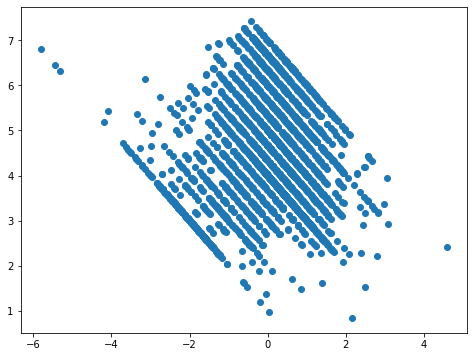

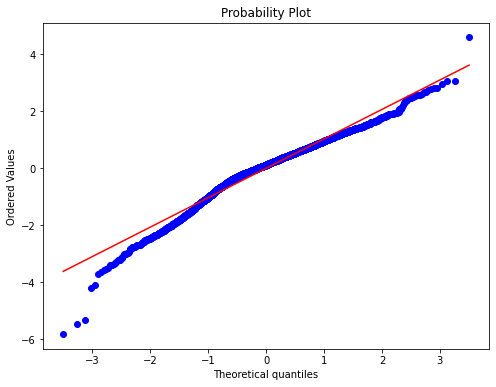

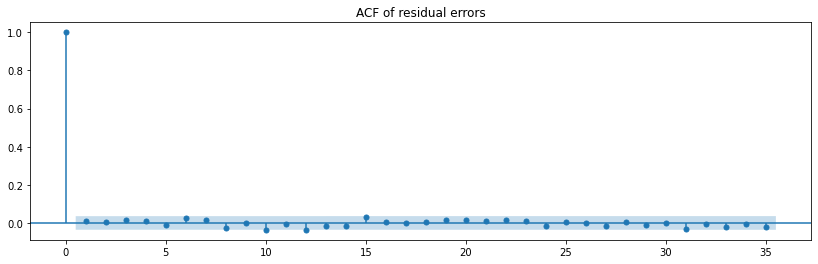

In [18]:
# Normality and autocorrelation of residuals
pred_val = avg_results.fittedvalues.copy()
true_val = y.values.copy()
residual = true_val - pred_val

fig, ax = plt.subplots(figsize=(8,6))
_ = ax.scatter(residual, pred_val)

fig, ax = plt.subplots(figsize=(8,6))
_, (__, ___, r) = sp.stats.probplot(residual, plot=ax, fit=True)

print(r**2)

plot_acf(avg_results.resid, title='ACF of residual errors')
plt.show()

In [19]:
# Data are normally distributed: Jarque-Bera
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sms.jarque_bera(avg_results.resid)
lzip(name, test)

[('Jarque-Bera', 450.02192057496603),
 ('Chi^2 two-tail prob.', 1.9009976473754918e-98),
 ('Skew', -0.6920522890417852),
 ('Kurtosis', 4.287260089248129)]

In [20]:
# Heteroskedasticity: Breush-Pagan test
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(avg_results.resid, X)
lzip(name, test)

[('Lagrange multiplier statistic', 256.41792303169774),
 ('p-value', 2.5340601127185674e-06),
 ('f-value', 1.714355218657887),
 ('f p-value', 2.1873114065439754e-07)]

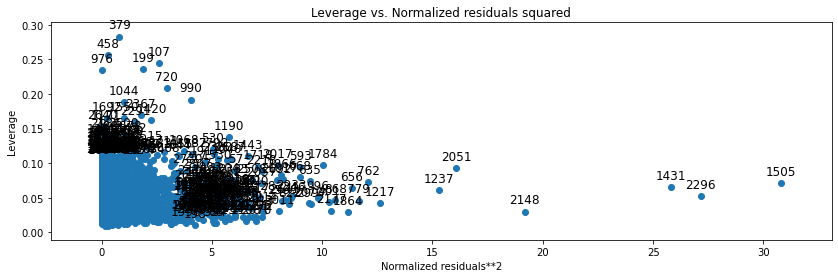

In [21]:
# Leverage/Outliers
sm.graphics.plot_leverage_resid2(avg_results)
plt.show()

In [22]:
y[1505], X.iloc[1505,:].T

(1.0,
 const                                                  1.00
 Call People                                            7.00
 Cleaning                                               1.00
 Cooking                                                7.00
 Crafting                                               1.00
 Create Online Content                                  7.00
 Drugs or Alcohol                                       7.00
 Exercise Indoors                                       7.00
 Exercise Outdoors                                      4.00
 Fashion                                                7.00
 Gardening                                              7.00
 Learning New Skills                                    7.00
 Making Music                                           7.00
 Meditating                                             7.00
 Music Listening                                        7.00
 Online Dating                                          4.00
 Photography      

#### Dependent Variable

<AxesSubplot:xlabel='avg_h', ylabel='Density'>

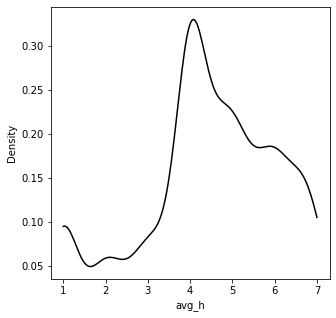

In [23]:
figure, ax = plt.subplots(figsize=(5,5))
sns.distplot(y, color='black',hist=False, kde_kws={"cut": 0})

#### **LightGBM**

In [24]:
dv = h_avg
h_avg_lgbmr = lgbmr_model(dv, data)

0.01543150341422013 % of correlations > 0.90

Best parameters found by grid search are: LGBMRegressor(learning_rate=0.05, max_depth=10, min_child_samples=10,
              num_leaves=40, random_state=123, subsample_for_bin=1000)

LightGBM Regression_r2: 0.5446
LightGBM Regression_Mean_squared_error: 1.0885
LightGBM Regression_Mean_absolute_error: 0.7732


### **SHAP Plots**
https://github.com/slundberg/shap/blob/master/README.md

SHAP: average of marginal contributions across all permutations. 

In [25]:
# load JS visualization code to notebook
shap.initjs()

regressor = h_avg_lgbmr
X = data.copy()

# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(X)

**Mean absolute value of the SHAP values for each feature to get a standard bar plot**

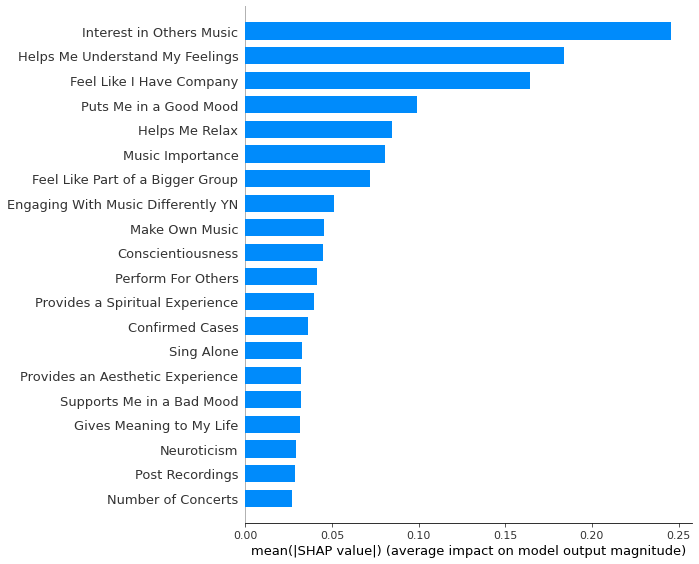

In [26]:
# Simple Feature Importance
shap.summary_plot(shap_values, X, plot_type="bar")

**To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot above sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the 
impacts each feature has on the model output. The color represents the feature value (red high, blue low).**

In [27]:
X['Helps Me Understand My Feelings'].value_counts(dropna=False, normalize=True).sort_index().round(4)*100

1.0     2.32
2.0     2.02
3.0     3.90
4.0    46.54
5.0    13.76
6.0    17.14
7.0    14.32
Name: Helps Me Understand My Feelings, dtype: float64

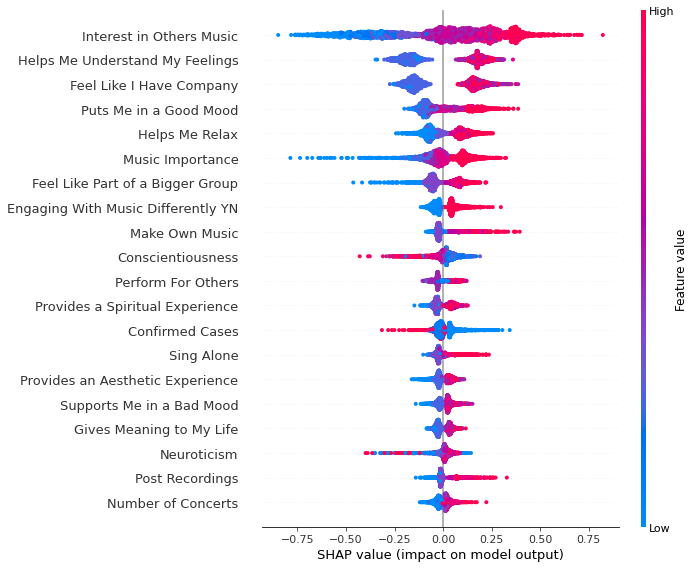

In [41]:
# Shap plot -- summarize the effects of ALL features
shap.summary_plot(shap_values, X, show=False)
f = plt.gcf()
f.savefig('shap_music_making.png', dpi=300)

In [30]:
top_features = ['Interest in Others Music',
                'Helps Me Understand My Feelings',
                'Feel Like I Have Company',
                'Puts Me in a Good Mood',
                'Music Importance',
                'Helps Me Relax',
                'Feel Like Part of a Bigger Group',
                'Provides a Spiritual Experience',
                'Perform For Others',
                'Engaging With Music Differently YN',
                'Conscientiousness',
                'Make Own Music',
                'Sing Alone',
                'Confirmed Cases',
                'Provides an Aesthetic Experience',
                'Supports Me in a Bad Mood',
                'Neuroticism',
                'Helps Me Accept My Situation',
                'Post Recordings',
                'Gives Meaning to My Life'
               ]

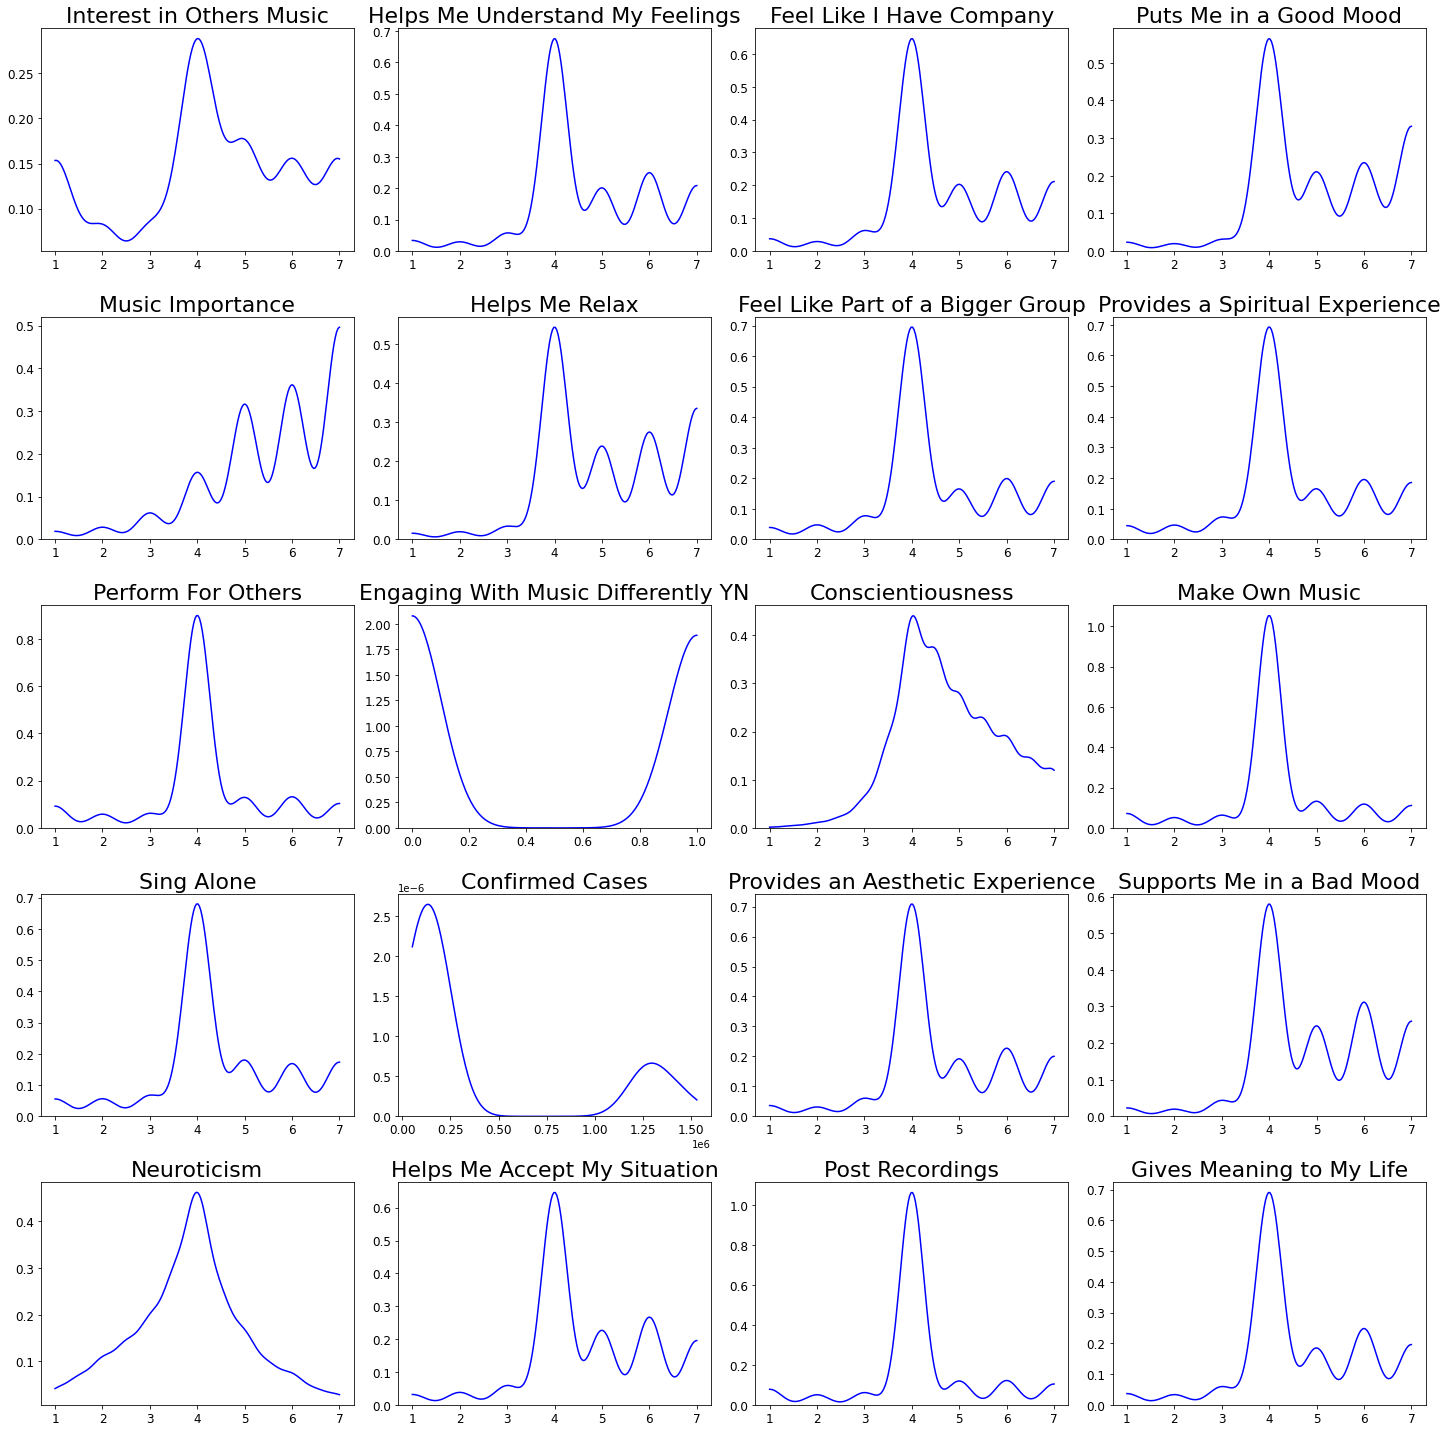

In [31]:
# distributions of top variables (like a histogram)
plt.figure(figsize=(20,20))
for i, column in enumerate(top_features):
    plt.subplot(5, 4, i+1)
    sns.distplot(X[column], color = 'b', hist = False, kde_kws={"cut": 0})
    plt.title(column, size = 22)
    plt.ylabel('')
    plt.xlabel('')
    plt.tight_layout()
    plt.tick_params(axis='both', which='major', labelsize=12)

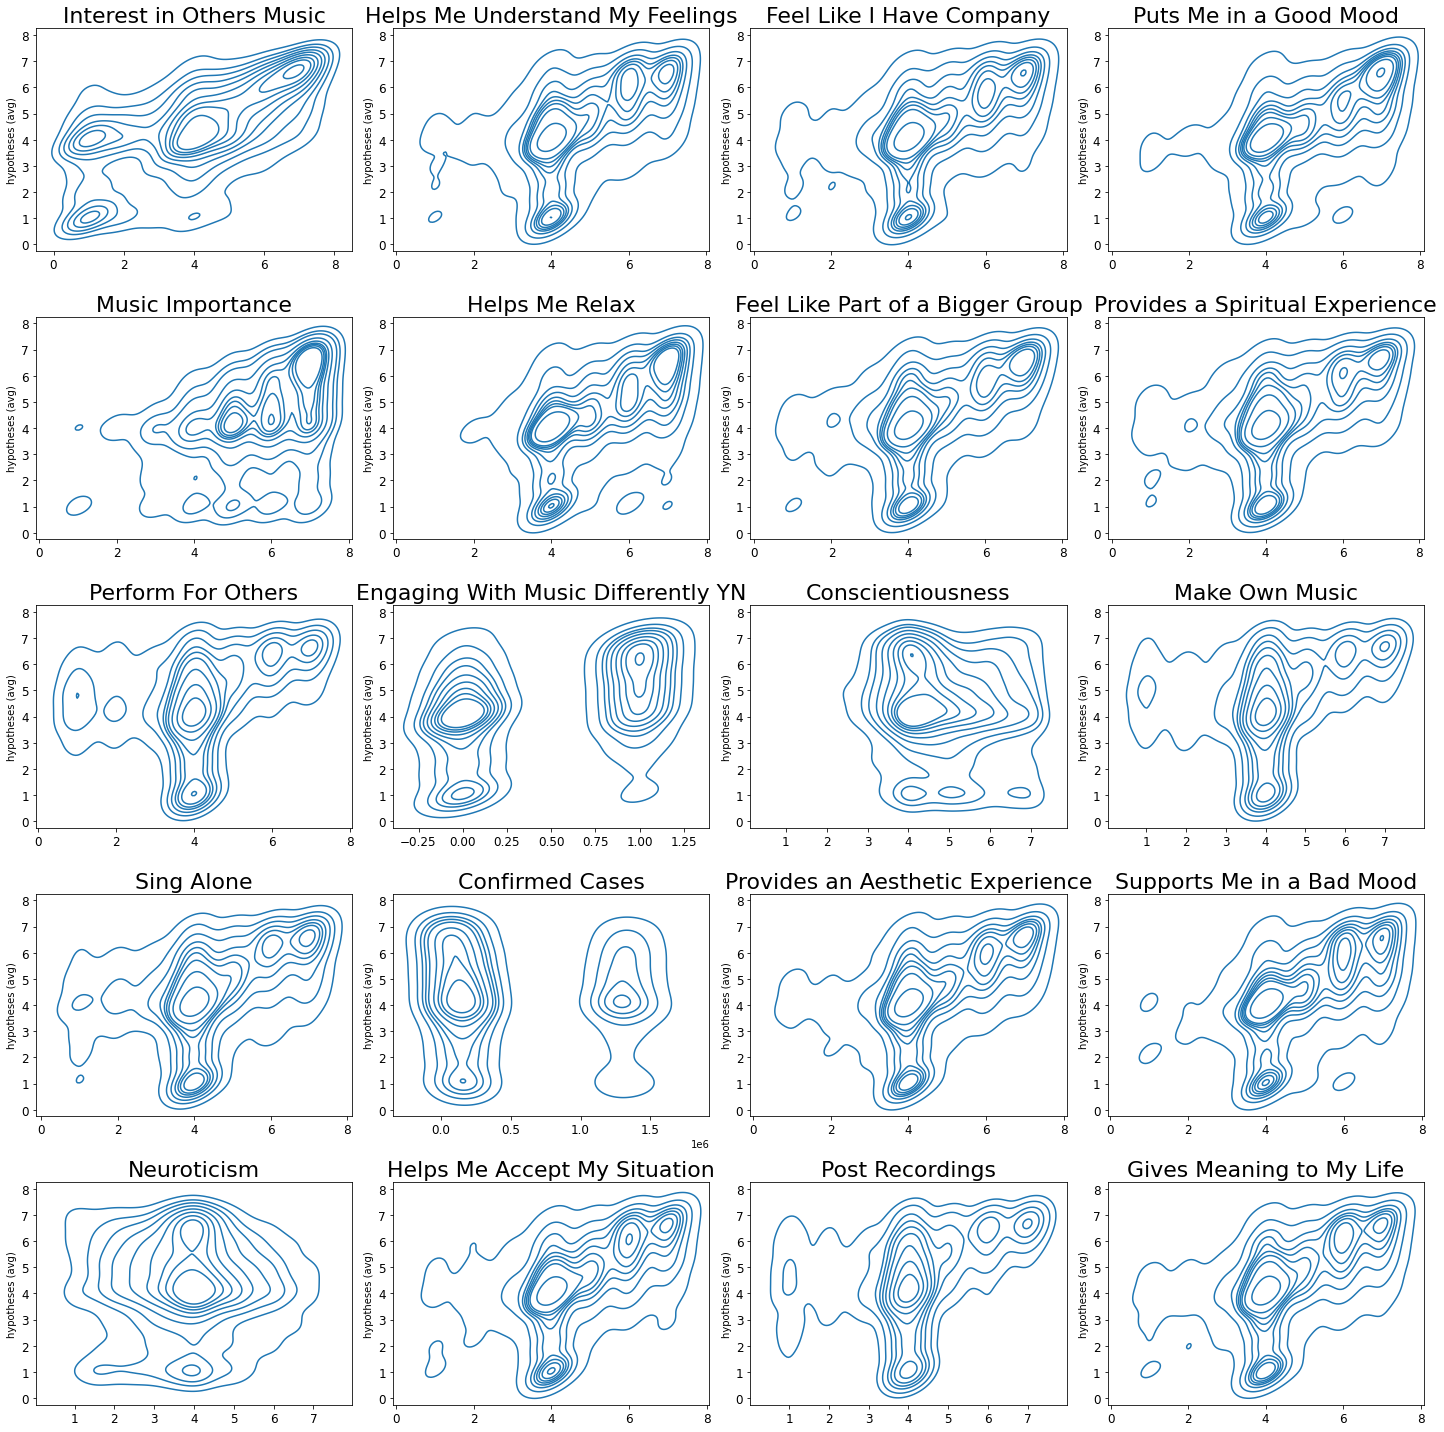

In [32]:
# density plot comparing how the top features vary with the dependent variable (avg of the hypotheses)
plt.figure(figsize=(20,20))
for i, column in enumerate(top_features):
    plt.subplot(5, 4, i+1)
    sns.kdeplot(x=X[column], y=y)
    plt.title(column, size = 22)
    plt.ylabel('hypotheses (avg)')
    plt.xlabel('')
    plt.tight_layout()
    plt.tick_params(axis='both', which='major', labelsize=12)